In [1]:
from torch.utils.data import Dataset
from datasets import load_dataset

from pathlib import Path
import os

import lightning.pytorch as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import cv2
import shutil
import numpy as np

from patchify import patchify

import nibabel as nib
import matplotlib.pyplot as plt

from nibabel.processing import resample_to_output

/home/pawel/Documents/RISA/magisterka/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CTDataset(Dataset):
    def __init__(self, images_ct_scans, images_ct_masks, transform=None):
        self.images_ct_scans = images_ct_scans
        self.images_ct_masks = images_ct_masks
        self.transform = transform

    def __len__(self):
        return len(self.images_ct_scans)

    def __getitem__(self, idx):
        image_file = self.images_ct_scans[idx]
        # print("image_file", image_file)
        # print("image_file.shape", image_file.shape)
        # print("images_ct_masks", self.images_ct_masks)
        # print("images_ct_masks.shape", self.images_ct_masks.shape)

        mask_file = self.images_ct_masks[idx]

        print(image_file.shape[-1])

        if self.transform is not None:
            transformed_images = []
            transformed_masks = []
            for i in range(0, image_file.shape[-1]):
                # print(image_file[..., i].shape)
                # print(i)
                # print("image_file[..., i]", image_file[..., i])
                image_slice = image_file[..., i]
                mask_slice = mask_file[..., i]

                transformed = self.transform(image=image_slice, mask=mask_slice)

                transformed_images.append(transformed["image"])
                transformed_masks.append(transformed["mask"])

            image_file = transformed_images
            mask_file = transformed_masks
        return image_file, mask_file

In [3]:
class CTDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
        A.Resize(height=50, width=50, interpolation=cv2.INTER_NEAREST),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        A.ToFloat(max_value=1024+400, always_apply=True),
        ToTensorV2()
        ])
        self.transforms = A.Compose([
        A.Resize(height=50, width=50, interpolation=cv2.INTER_NEAREST),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        A.ToFloat(max_value=1024+400, always_apply=True),
        ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        self.ct_dataset= None

        self.all_ct_scan_patches = []
        self.all_ct_mask_patches = []


    def prepare_data(self):
        self.ct_dataset = load_dataset("andreped/AeroPath")

        print('len dataset', self.ct_dataset['test'].num_rows)

        print(self.ct_dataset)

        for img in range(len(self.ct_dataset['test'])):
            # print(img)     #just stop here to see all file names printed
                    
            large_image = self.ct_dataset['test'][img]

            ct_image = nib.load(large_image["ct"])
            ct_image = resample_to_output(ct_image, order=1)
            ct_data_scan = ct_image.get_fdata().astype("int32")
            ct_data_scan[ct_data_scan < -1024] = -1024
            ct_data_scan[ct_data_scan > 400] = 400

            ct_data_scan = ct_data_scan + 1024
            # print('shape: ', ct_data_scan.shape)

            # print('image: ', ct_data_scan)

            # break

            ct_mask = nib.load(large_image["airways"])
            ct_mask = resample_to_output(ct_mask, order=1)
            ct_data_mask = ct_mask.get_fdata().astype("uint8")
                    
            percent_size_x = 0.5  # Przykładowo 20% w osi X
            percent_size_y = 0.5  # Przykładowo 20% w osi Y
            fixed_size_z = 50  # Stała liczba sliców w osi Z

            scan_shape = ct_data_scan.shape

            patch_size_x = min(int(round(scan_shape[0] * percent_size_x)), scan_shape[0])
            patch_size_y = min(int(round(scan_shape[1] * percent_size_y)), scan_shape[1])

            patch_size = (patch_size_x, patch_size_y, fixed_size_z)

            print("patch_size", patch_size)

            step = patch_size

            patches_scan = patchify(ct_data_scan, patch_size, step=step)
            patches_mask = patchify(ct_data_mask, patch_size, step=step)

            # Pętle do iteracji przez otrzymane fragmenty danego skanu
            for i in range(patches_scan.shape[0]):
                for j in range(patches_scan.shape[1]):
                    for k in range(patches_scan.shape[2]):
                        patch_scan = patches_scan[i, j, k, :, :, :]
                        patch_mask = patches_mask[i, j, k, :, :, :]
                            
                        self.all_ct_scan_patches.append(patch_scan)
                        self.all_ct_mask_patches.append(patch_mask)

            print("self.all_ct_scan_patches.shape", len(self.all_ct_scan_patches))
            print("self.all_ct_mask_patches.shape", len(self.all_ct_mask_patches))

##################################################################### for testing purposes
            print(len(self.all_ct_scan_patches))
            fig, ax = plt.subplots(2, 2, figsize=(20, 12))
            ax[0,0].cla()
            ax[0,1].cla()
            ax[1,0].cla()
            ax[1,1].cla()
            ax[0,0].imshow(self.all_ct_scan_patches[0][..., 1], cmap="gray")
            ax[0,1].imshow(self.all_ct_scan_patches[patches_scan.shape[2] + 1][..., 1], cmap="gray")
            ax[1,0].imshow(self.all_ct_scan_patches[2*patches_scan.shape[2] + 1][..., 1], cmap="gray")
            ax[1,1].imshow(self.all_ct_scan_patches[3*patches_scan.shape[2] + 1][..., 1], cmap="gray")

            print("image: ", self.all_ct_scan_patches[0][..., 49])
            print("shape: ", self.all_ct_scan_patches[0][..., 49].shape)

            plt.show()

            break
#####################################################################

        # images = np.array(all_img_patches)
        # images = np.expand_dims(images, -1)
                        
            if img == 1:
                break


    def setup(self):
        # Split the data and assign datasets for use in dataloaders

        all_indices = np.arange(len(self.all_ct_scan_patches))

        # self.all_ct_scan_patches = np.array([np.array(patch) for patch in self.all_ct_scan_patches])
        # self.all_ct_mask_patches = np.array([np.array(patch) for patch in self.all_ct_mask_patches])

        self.all_ct_scan_patches = np.array(self.all_ct_scan_patches, dtype=object)
        self.all_ct_mask_patches = np.array(self.all_ct_mask_patches, dtype=object)

        train_index, val_index = train_test_split(all_indices, test_size = 0.3, random_state=42)
        val_index, test_index = train_test_split(val_index, test_size = 0.5, random_state=42)

        # print('Typ 1:', self.all_ct_scan_patches)
        # print('Typ 2:', type(self.all_ct_mask_patches))
        print('Indeksy zbioru walidacyjnego:', val_index)
        print('Indeksy zbioru testowego:', test_index)
        print('Indeksy zbioru treningowego:', train_index)

        train_scans = self.all_ct_scan_patches[train_index]
        train_masks = self.all_ct_mask_patches[train_index]

        val_scans = self.all_ct_scan_patches[val_index]
        val_masks = self.all_ct_mask_patches[val_index]

        test_scans = self.all_ct_scan_patches[test_index]
        test_masks = self.all_ct_mask_patches[test_index]


        self.train_dataset = CTDataset(train_scans, train_masks, transform=self.augmentations)
        self.val_dataset = CTDataset(val_scans, val_masks, transform=self.transforms)
        self.test_dataset = CTDataset(test_scans, test_masks, transform=self.transforms)

        data, mask = self.train_dataset.__getitem__(0)
        print("len1", len(data))
        print("len2", len(data[0]))
        print("data", data)

        print(self.train_dataset)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=12)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=12)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=12)

len dataset 27
DatasetDict({
    test: Dataset({
        features: ['ct', 'airways', 'lungs'],
        num_rows: 27
    })
})
patch_size (194, 194, 50)
self.all_ct_scan_patches.shape 28
self.all_ct_mask_patches.shape 28
28
image:  [[   0    0    0 ...   29    3    8]
 [   0    0    0 ...   20    4   19]
 [   0    0    0 ...   28   20   23]
 ...
 [ 125  122  122 ... 1008 1057 1086]
 [ 119  116  105 ... 1060 1063 1108]
 [ 129  146  134 ... 1049 1125 1121]]
shape:  (194, 194)


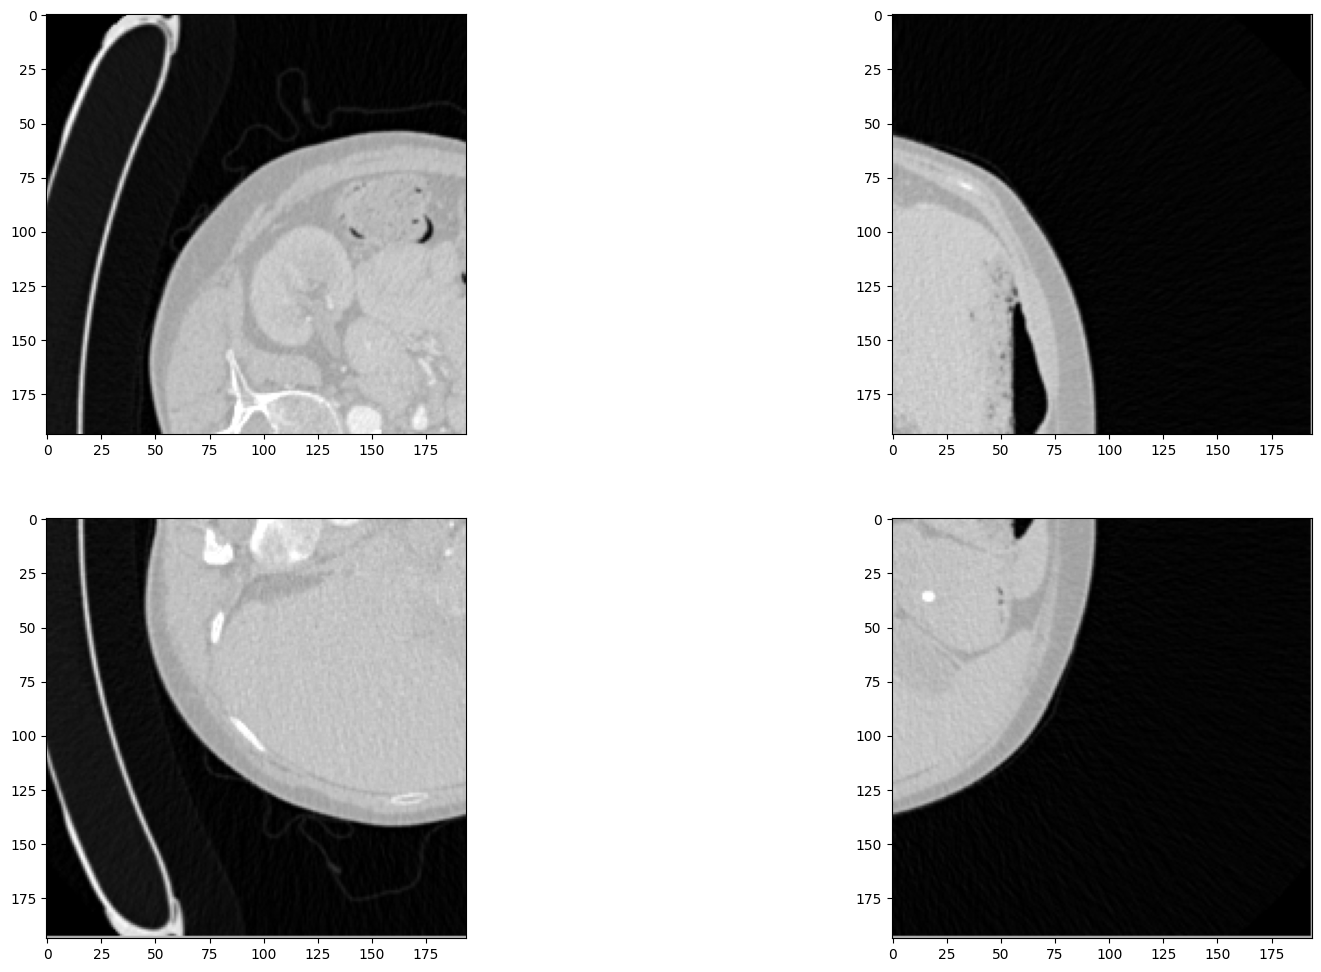

In [4]:
datamodule = CTDataModule()
datamodule.prepare_data()
# datamodule.setup()